In [74]:
from eye_contact_frames import eye_contact_frames 
import pandas as pd

from sklearn.metrics import accuracy_score, balanced_accuracy_score

In [21]:
list_annotated = eye_contact_frames("annotations/annotations_5.xml", 6378)

1925


In [37]:
list_annotated
from collections import Counter

print(Counter(list_annotated).keys()) # equals to list(set(words))
Counter(list_annotated).values() # counts the elements' frequency

dict_keys([1.0, 0.0])


dict_values([1925, 4453])

In [40]:
df_annotated = pd.DataFrame(list_annotated, columns= ["annotated"])
df_annotated

,annotated
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
6373,1.0
6374,1.0
6375,1.0
6376,1.0


In [23]:
df = pd.read_csv("video_annot5_output.txt", names = ["frame", "acc"])

In [30]:
df["rounded"] = pd.Series([x>.7 for x in df.acc])
df[df.rounded]

df.replace({True : 1, False : 0}, inplace=True)

In [31]:
df

,frame,acc,rounded
0,2,0.261932,0
1,12,0.234186,0
2,13,0.266573,0
3,15,0.206249,0
4,16,0.213829,0
...,...,...,...
2762,4025,0.563366,0
2763,4026,0.594875,0
2764,4026,0.012109,0
2765,4027,0.008396,0


In [6]:
# bestimme accuracy von list_annotated und df
# dafür nur eine spalte von df nötig und dann 
# von sklearn die accuracy funktion


# vorher df runden!

In [ ]:
accuracy_score()

# merge annotated and real

In [51]:
merged = pd.merge(df, df_annotated, left_on = "frame", right_index=True)
merged

,frame,acc,rounded,annotated
0,2,0.261932,0,1.0
1,12,0.234186,0,1.0
2,13,0.266573,0,1.0
3,15,0.206249,0,1.0
4,16,0.213829,0,1.0
...,...,...,...,...
2762,4025,0.563366,0,0.0
2763,4026,0.594875,0,0.0
2764,4026,0.012109,0,0.0
2765,4027,0.008396,0,0.0


In [52]:
accuracy_score(merged.annotated, merged.rounded)

0.5952294904228406

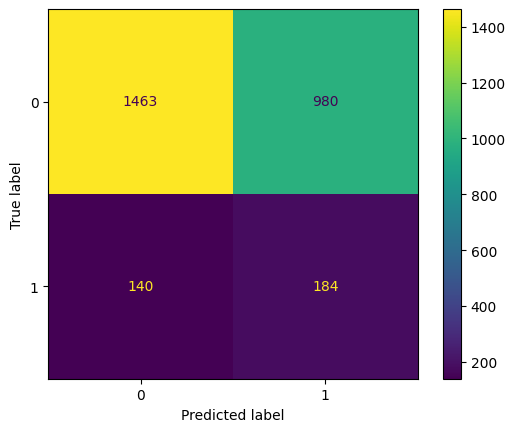

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
ConfusionMatrixDisplay(confusion_matrix(merged.rounded, merged.annotated)).plot();

In [82]:
merged.annotated

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2762    0.0
2763    0.0
2764    0.0
2765    0.0
2766    0.0
Name: annotated, Length: 2767, dtype: float64

In [83]:
print(classification_report(merged.annotated, [x>.7 for x in merged.acc]))

              precision    recall  f1-score   support

         0.0       0.60      0.91      0.72      1603
         1.0       0.57      0.16      0.25      1164

    accuracy                           0.60      2767
   macro avg       0.58      0.54      0.49      2767
weighted avg       0.59      0.60      0.52      2767



0.5 0.5388507408745934 0.5004745719473581
0.55 0.5543910372244308 0.5102401425162871
0.6000000000000001 0.5746295627032888 0.5240606101532136
0.6500000000000001 0.5876400433682689 0.5316427746086054
0.7000000000000002 0.5952294904228406 0.5353696784165429
0.7500000000000002 0.6042645464401879 0.5409324333884277
0.8000000000000003 0.6064329598843513 0.5403335241267984
0.8500000000000003 0.6064329598843513 0.5382160382272929
0.9000000000000004 0.597397903867004 0.5247715301850268
0.9500000000000004 0.5865558366461872 0.5087087033976243


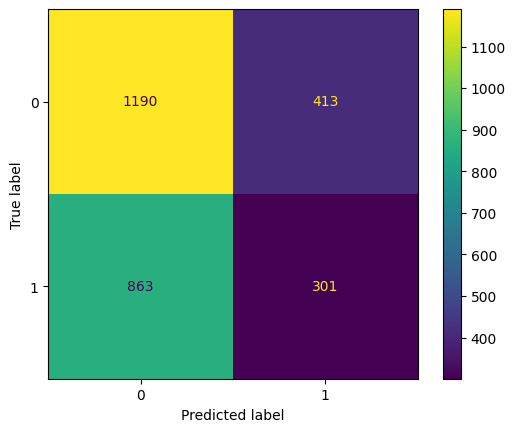

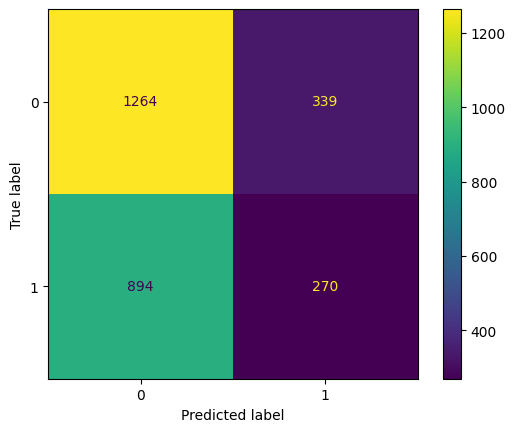

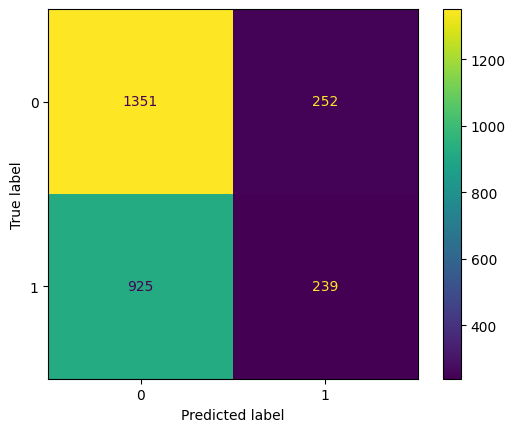

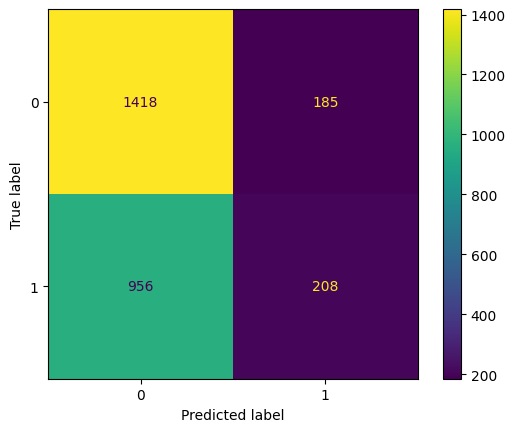

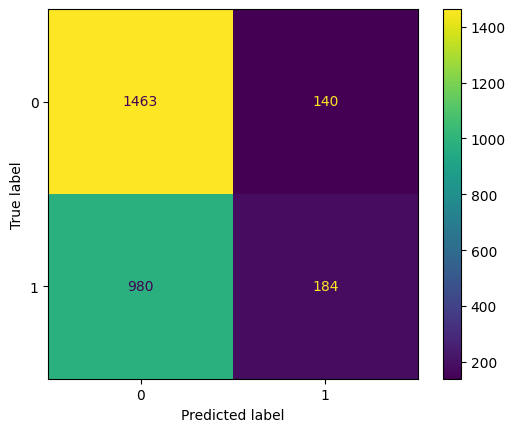

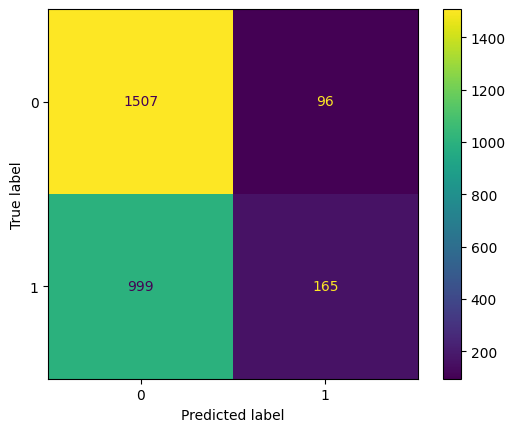

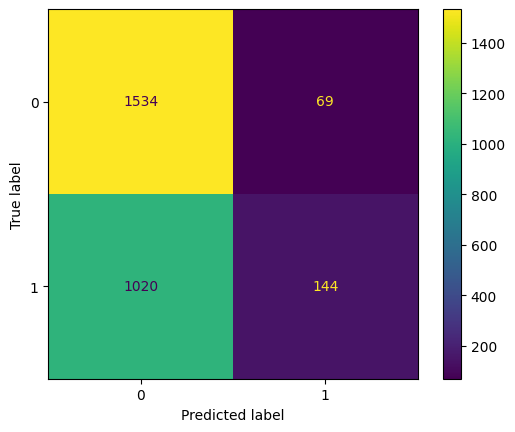

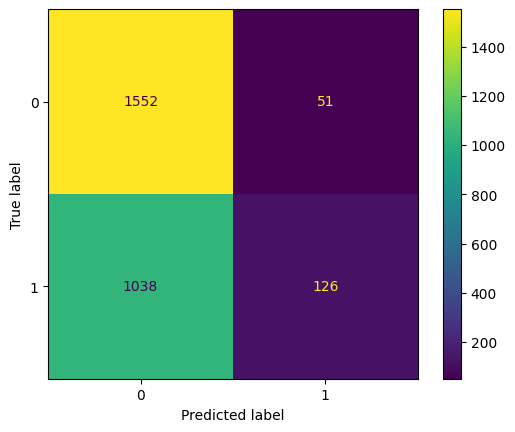

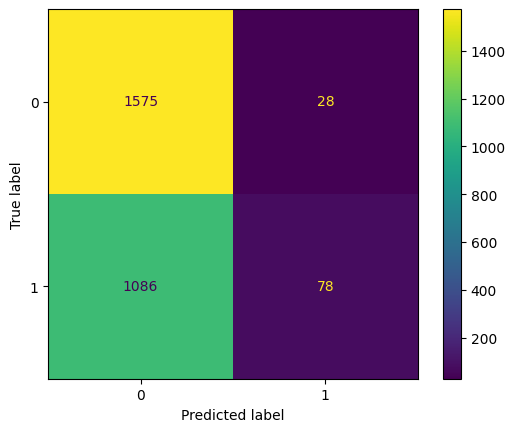

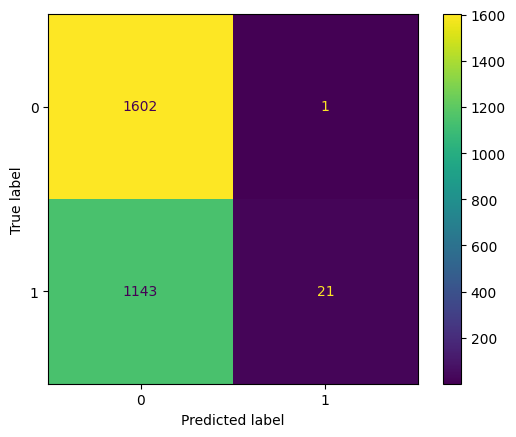

In [76]:
def view(threshold, annotations, real):
    real_rounded = [x>threshold for x in real]
    print(threshold, accuracy_score(annotations, real_rounded), balanced_accuracy_score(annotations, real_rounded))
    ConfusionMatrixDisplay(confusion_matrix(annotations, real_rounded)).plot();
import numpy as np
for threshold in np.arange(.5, 1, .05):
    view(threshold, merged.annotated, merged.acc)

In [68]:
import numpy as np
for threshold in np.arange(.5, 1, .05):
    print(threshold)

0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000002
0.7500000000000002
0.8000000000000003
0.8500000000000003
0.9000000000000004
0.9500000000000004
